In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from PIL import Image
import random
import math
import matplotlib.pyplot as plt
import dendropy
import csv
from dendropy.calculate import treecompare
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
training_data = np.load('./output/training_data.npy')
training_labels = np.load('./output/training_dists.npy')

#pad the training data matrix so it is 100x1024

#(500, 100, 1000, 1)

# zero_padding_array = np.zeros((500,100,600,1))

In [3]:
BRANCH_NUM = 100
SEQUENCE_LEN = 1000

OUTPUT_DIST_NUM = int((BRANCH_NUM + 1) * BRANCH_NUM / 2)

In [4]:
training_data.shape

(500, 100, 1000, 1)

In [5]:
training_labels.shape

(500, 5050)

In [6]:
# zero_padding_array.shape

In [7]:
# print(training_data.shape)
# training_data = np.concatenate([training_data, zero_padding_array], axis=2)
print(training_data.shape)

print(training_labels.shape)

samples_count = training_data.shape[0]

train_size = math.floor(0.85*training_data.shape[0])

shuffle_indices = random.sample(range(0, samples_count), samples_count)

indices_train = shuffle_indices[0:train_size]
indices_test = shuffle_indices[train_size:samples_count]

X_train = training_data[indices_train,:]
Y_train = training_labels[indices_train]

X_test = training_data[indices_test,:]
Y_test = training_labels[indices_test]

print('X_train.shape : ', X_train.shape)
print('X_test.shape : ', X_test.shape)

print('Y_train.shape : ', Y_train.shape)
print('Y_test.shape : ', Y_test.shape)

np.save('./output/X_test.npy', X_test)
np.save('./output/Y_test.npy', Y_test)


(500, 100, 1000, 1)
(500, 5050)
X_train.shape :  (425, 100, 1000, 1)
X_test.shape :  (75, 100, 1000, 1)
Y_train.shape :  (425, 5050)
Y_test.shape :  (75, 5050)


In [8]:
# model = Sequential()

# # Layer 1
# model.add(Conv2D(64, input_shape=X_train.shape[1:], kernel_size=(3,3), strides=(1,1), padding='same'))
# #model.add(Conv2D(48, input_shape=(400,11,1), kernel_size=(2,2), strides=(1,1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(1, 2)))

# # Layer 2
# model.add(Conv2D(32, (3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(1, 2)))

# # Layer 3
# model.add(Conv2D(16, (3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(1, 2)))

# # Layer 4
# model.add(Conv2D(1, (2, 1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(1, 2)))


In [9]:
model = Sequential()

# Layer 1
model.add(Conv2D(10, input_shape=X_train.shape[1:], kernel_size=(3,3), strides=(1,1)))
#model.add(Conv2D(48, input_shape=(400,11,1), kernel_size=(2,2), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Conv2D(5, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(Conv2D(5, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
model.add(Conv2D(1, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 5
model.add(Flatten())
model.add(Dense(OUTPUT_DIST_NUM, activation='relu'))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 998, 10)       100       
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 998, 10)       40        
_________________________________________________________________
activation_1 (Activation)    (None, 98, 998, 10)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 499, 10)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 497, 5)        455       
_________________________________________________________________
batch_normalization_2 (Batch (None, 47, 497, 5)        20        
_________________________________________________________________
activation_2 (Activation)    (None, 47, 497, 5)       

In [11]:
# (4) Compile 
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [12]:
loss_list_epoch = []
RF_avg_distance_epoch = []
RF_list_distance_epoch = []

In [13]:
## This function is defined for vector -> symmetric distance matrix
def utri2mat(utri):
    n = int(-1 + np.sqrt(1 + 8*len(utri))) // 2
    iu1 = np.triu_indices(n)
    ret = np.empty((n, n))
    ret[iu1] = utri
    ret.T[iu1] = utri
    return ret

In [14]:
# (5) Train
for i in range(60):
    print("******** Start fitting model ********")
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=16, epochs=1, verbose=1)
    print(history.history['loss'])
    loss_list_epoch.append(history.history['loss'][0])

    print("******** Start calculating RF Distance ********")
    RF_list_distance = []
    for index in range(len(X_train)):
        tips_num = np.count_nonzero(np.sum(X_train[index], axis=1) != 0) 
#         print("tips_num: ", tips_num)
        array_selection_length = int((tips_num + 1) * tips_num / 2)
        Y_train_vec_sel = Y_train[index][0:array_selection_length]
        X_train_results = model.predict(X_train[index].reshape((1, 100, 1000, 1)))
        X_train_results_vec_sel = X_train_results[0][0:array_selection_length]
        original_dis_matrix = utri2mat(Y_train_vec_sel)
        new_dis_matrix = utri2mat(X_train_results_vec_sel)
        for i in range(len(new_dis_matrix)):
            new_dis_matrix[i,i] = 0
        with open('./output/original_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
            csvWriter = csv.writer(my_csv,delimiter=',')
            csvWriter.writerows(original_dis_matrix)
        with open('./output/new_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
            csvWriter = csv.writer(my_csv,delimiter=',')
            csvWriter.writerows(new_dis_matrix)
        taxon_namespace = dendropy.TaxonSet()
        pdm_origin = dendropy.PhylogeneticDistanceMatrix.from_csv(
                src=open('./output/original_dis_matrix'+str(index)+'.csv'),
                is_first_row_column_names=False,
                is_first_column_row_names=False,
                delimiter=",",
                taxon_namespace = taxon_namespace)
        pdm_new = dendropy.PhylogeneticDistanceMatrix.from_csv(
                src=open('./output/new_dis_matrix'+str(index)+'.csv'),
                is_first_row_column_names=False,
                is_first_column_row_names=False,
                delimiter=",",
                taxon_namespace = taxon_namespace)
        tree_origin = pdm_origin.nj_tree()
        tree_new = pdm_new.nj_tree()
        RF_distance = treecompare.symmetric_difference(tree_origin, tree_new)
        RF_list_distance.append(RF_distance)
    RF_list_distance_epoch.append(RF_list_distance)
    RF_avg_distance_epoch.append(sum(RF_list_distance) / len(RF_list_distance))
    print("RF_list_distance: ", RF_list_distance)
    print("RF_avg_distance_epoch: ", RF_avg_distance_epoch)
# history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=16, epochs=600, verbose=1)
model.save('./output/CNN_model_03.h5')

******** Start fitting model ********
Train on 425 samples, validate on 75 samples
Epoch 1/1
425/425 [==============================] - 12s 27ms/step - loss: 0.2555 - accuracy: 0.0024 - val_loss: 0.3136 - val_accuracy: 0.0000e+00
[0.2554580793310614]
******** Start calculating RF Distance ********


/home/howard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: CriticalDeprecationWarning: Deprecated since DendroPy 4: 'TaxonSet' will no longer be supported in future releases; use 'TaxonNamespace' instead


RF_list_distance:  [130, 140, 110, 118, 104, 126, 114, 106, 122, 136, 70, 122, 138, 126, 94, 140, 130, 104, 114, 50, 132, 130, 112, 44, 106, 40, 112, 84, 126, 126, 112, 80, 46, 122, 128, 120, 108, 106, 118, 130, 44, 124, 122, 124, 120, 140, 120, 126, 40, 120, 94, 94, 126, 126, 92, 126, 42, 56, 112, 52, 44, 130, 106, 62, 128, 130, 104, 118, 138, 138, 114, 118, 70, 114, 44, 106, 106, 104, 104, 120, 124, 114, 132, 116, 112, 134, 96, 124, 120, 128, 140, 126, 140, 60, 110, 106, 108, 120, 118, 106, 112, 108, 56, 108, 144, 112, 110, 124, 130, 112, 126, 70, 74, 136, 70, 44, 82, 112, 108, 120, 112, 104, 122, 122, 126, 54, 122, 104, 126, 106, 104, 124, 94, 110, 84, 132, 96, 122, 82, 106, 124, 120, 128, 104, 46, 110, 110, 120, 126, 126, 132, 124, 42, 122, 128, 88, 136, 96, 124, 114, 94, 70, 108, 102, 130, 74, 100, 118, 122, 120, 126, 116, 126, 58, 130, 114, 110, 112, 136, 134, 124, 106, 126, 92, 124, 122, 124, 108, 124, 108, 120, 94, 120, 118, 130, 96, 116, 132, 116, 114, 58, 112, 106, 134, 128, 

425/425 [==============================] - 10s 23ms/step - loss: 0.1902 - accuracy: 0.0024 - val_loss: 0.3101 - val_accuracy: 0.0000e+00
[0.19018601221196793]
******** Start calculating RF Distance ********
RF_list_distance:  [130, 138, 108, 118, 102, 126, 112, 110, 122, 134, 70, 122, 138, 126, 94, 134, 130, 104, 114, 48, 132, 134, 112, 44, 108, 40, 112, 84, 126, 122, 112, 80, 42, 122, 124, 122, 110, 106, 116, 128, 44, 124, 122, 124, 118, 136, 120, 126, 40, 122, 92, 92, 126, 126, 94, 126, 42, 58, 108, 54, 44, 128, 110, 62, 126, 130, 108, 118, 138, 136, 116, 116, 72, 114, 42, 106, 106, 102, 106, 122, 122, 114, 132, 118, 112, 134, 96, 126, 126, 130, 136, 126, 140, 60, 112, 106, 108, 118, 116, 104, 108, 108, 56, 112, 144, 112, 114, 124, 130, 114, 126, 70, 72, 136, 70, 44, 80, 108, 110, 120, 114, 108, 122, 126, 124, 56, 122, 104, 126, 100, 104, 124, 94, 112, 84, 132, 96, 124, 82, 106, 126, 120, 126, 106, 44, 112, 112, 120, 126, 128, 130, 124, 42, 128, 126, 88, 130, 96, 120, 112, 94, 70, 11

425/425 [==============================] - 10s 23ms/step - loss: 0.1766 - accuracy: 0.0000e+00 - val_loss: 0.3096 - val_accuracy: 0.0000e+00
[0.17664708740570967]
******** Start calculating RF Distance ********
RF_list_distance:  [130, 134, 106, 118, 104, 126, 116, 110, 122, 132, 68, 122, 136, 126, 90, 140, 128, 104, 116, 48, 132, 134, 112, 44, 108, 40, 112, 84, 126, 122, 112, 80, 42, 120, 128, 118, 110, 106, 116, 130, 42, 124, 122, 122, 120, 140, 120, 126, 40, 122, 88, 94, 124, 126, 94, 126, 40, 58, 110, 52, 42, 130, 108, 62, 128, 130, 108, 120, 140, 136, 116, 118, 70, 114, 40, 108, 106, 106, 108, 120, 126, 112, 132, 118, 114, 132, 94, 126, 128, 128, 138, 126, 140, 60, 112, 106, 106, 118, 120, 108, 108, 108, 54, 110, 144, 112, 114, 124, 130, 114, 126, 64, 76, 136, 70, 44, 80, 112, 110, 122, 114, 108, 120, 126, 124, 56, 124, 104, 124, 104, 102, 124, 94, 112, 82, 134, 96, 124, 82, 106, 126, 122, 128, 106, 44, 110, 112, 118, 124, 126, 130, 124, 40, 126, 126, 86, 134, 96, 118, 112, 92, 70

425/425 [==============================] - 9s 22ms/step - loss: 0.1669 - accuracy: 0.0000e+00 - val_loss: 0.2883 - val_accuracy: 0.0000e+00
[0.1669335571457358]
******** Start calculating RF Distance ********
RF_list_distance:  [130, 138, 110, 116, 104, 126, 114, 108, 122, 136, 66, 122, 136, 126, 90, 134, 130, 104, 116, 46, 132, 132, 110, 40, 106, 40, 112, 80, 126, 126, 114, 76, 42, 122, 128, 120, 110, 108, 114, 130, 42, 124, 122, 120, 120, 140, 118, 126, 40, 120, 80, 94, 126, 126, 94, 126, 32, 58, 110, 52, 42, 130, 108, 62, 128, 130, 106, 120, 142, 134, 114, 120, 58, 112, 42, 106, 106, 104, 106, 120, 124, 114, 134, 118, 110, 134, 94, 122, 122, 128, 140, 126, 140, 60, 112, 104, 106, 120, 118, 104, 110, 104, 54, 108, 144, 112, 114, 122, 128, 114, 124, 36, 72, 136, 68, 32, 78, 110, 108, 120, 114, 98, 120, 126, 126, 56, 122, 104, 126, 102, 102, 118, 94, 108, 82, 132, 96, 122, 78, 110, 126, 122, 128, 106, 28, 114, 112, 120, 124, 126, 126, 122, 40, 128, 128, 80, 136, 96, 118, 112, 94, 70, 1

425/425 [==============================] - 13s 30ms/step - loss: 0.1598 - accuracy: 0.0118 - val_loss: 0.2779 - val_accuracy: 0.0000e+00
[0.15978596228010514]
******** Start calculating RF Distance ********
RF_list_distance:  [124, 138, 104, 116, 104, 126, 110, 106, 120, 136, 68, 122, 138, 126, 94, 134, 130, 104, 116, 46, 132, 130, 108, 42, 106, 40, 112, 78, 124, 124, 108, 76, 38, 122, 130, 122, 110, 108, 116, 128, 42, 124, 122, 120, 118, 140, 120, 126, 36, 122, 80, 94, 126, 124, 92, 126, 32, 58, 110, 52, 44, 128, 108, 62, 126, 128, 104, 120, 138, 134, 116, 120, 58, 112, 44, 104, 106, 104, 100, 122, 124, 114, 134, 118, 108, 132, 94, 120, 124, 126, 140, 126, 136, 60, 110, 102, 106, 118, 120, 100, 108, 100, 52, 108, 142, 110, 112, 124, 128, 114, 124, 34, 72, 134, 66, 34, 80, 110, 108, 120, 114, 102, 118, 126, 124, 54, 126, 104, 120, 102, 104, 120, 94, 110, 84, 132, 96, 120, 72, 108, 126, 116, 128, 106, 30, 114, 112, 120, 122, 128, 132, 124, 36, 126, 128, 84, 134, 96, 122, 112, 94, 70, 11

425/425 [==============================] - 11s 26ms/step - loss: 0.1552 - accuracy: 0.0141 - val_loss: 0.2304 - val_accuracy: 0.0000e+00
[0.1551670744489221]
******** Start calculating RF Distance ********
RF_list_distance:  [126, 138, 100, 112, 104, 126, 114, 106, 122, 134, 68, 122, 134, 122, 90, 134, 128, 104, 114, 40, 132, 132, 110, 38, 106, 40, 110, 72, 126, 124, 108, 74, 34, 122, 126, 118, 110, 108, 114, 130, 44, 124, 120, 120, 118, 140, 116, 126, 38, 122, 76, 94, 124, 126, 94, 124, 32, 58, 106, 50, 44, 128, 108, 62, 126, 130, 106, 120, 140, 134, 114, 120, 62, 112, 42, 106, 106, 102, 106, 122, 124, 112, 128, 116, 110, 128, 94, 120, 126, 124, 138, 124, 138, 60, 106, 102, 102, 116, 118, 104, 106, 106, 48, 106, 144, 112, 110, 124, 124, 112, 124, 32, 62, 136, 70, 32, 80, 110, 106, 120, 110, 102, 116, 126, 126, 48, 122, 104, 126, 102, 102, 118, 92, 108, 82, 132, 92, 124, 74, 104, 126, 122, 126, 106, 14, 114, 110, 118, 120, 124, 130, 120, 38, 128, 128, 80, 134, 94, 116, 112, 92, 68, 108

425/425 [==============================] - 9s 21ms/step - loss: 0.1483 - accuracy: 0.0188 - val_loss: 0.2184 - val_accuracy: 0.0000e+00
[0.14830645731266806]
******** Start calculating RF Distance ********
RF_list_distance:  [130, 138, 108, 112, 102, 126, 112, 106, 120, 134, 68, 122, 134, 124, 88, 138, 126, 104, 112, 38, 132, 130, 110, 38, 110, 40, 112, 70, 126, 126, 114, 78, 34, 122, 126, 120, 110, 108, 114, 130, 42, 122, 120, 120, 118, 140, 120, 122, 38, 122, 80, 94, 126, 122, 92, 126, 34, 56, 110, 50, 44, 126, 106, 60, 126, 130, 106, 120, 140, 132, 110, 120, 62, 108, 44, 106, 104, 102, 108, 120, 126, 114, 132, 114, 112, 134, 94, 124, 126, 122, 136, 122, 140, 58, 112, 106, 104, 118, 116, 108, 102, 106, 48, 108, 144, 112, 114, 122, 126, 110, 122, 18, 72, 134, 68, 24, 80, 112, 108, 120, 114, 104, 120, 122, 126, 52, 122, 104, 122, 102, 102, 120, 92, 110, 82, 134, 94, 124, 72, 106, 126, 122, 128, 108, 16, 114, 112, 118, 120, 126, 132, 122, 38, 126, 126, 80, 134, 94, 118, 110, 94, 70, 112

425/425 [==============================] - 10s 24ms/step - loss: 0.1442 - accuracy: 0.0212 - val_loss: 0.2313 - val_accuracy: 0.0000e+00
[0.14422242473153507]
******** Start calculating RF Distance ********
RF_list_distance:  [126, 138, 102, 114, 104, 124, 114, 108, 118, 134, 68, 120, 134, 126, 92, 136, 128, 104, 112, 42, 132, 130, 110, 36, 106, 40, 112, 68, 126, 126, 114, 76, 40, 122, 128, 120, 110, 108, 116, 130, 44, 124, 118, 120, 116, 138, 118, 124, 36, 122, 82, 94, 124, 126, 90, 126, 32, 56, 112, 52, 44, 128, 106, 60, 126, 130, 106, 118, 140, 138, 116, 120, 58, 110, 44, 108, 106, 104, 104, 118, 124, 114, 128, 116, 114, 132, 94, 122, 126, 126, 140, 126, 138, 58, 112, 102, 108, 118, 116, 104, 106, 108, 50, 108, 144, 110, 114, 120, 126, 112, 120, 38, 76, 136, 66, 32, 78, 112, 110, 120, 112, 104, 120, 126, 124, 54, 126, 104, 122, 96, 102, 118, 94, 106, 84, 132, 94, 120, 78, 108, 126, 122, 128, 106, 20, 112, 112, 120, 124, 126, 128, 122, 38, 126, 128, 82, 134, 96, 124, 108, 90, 70, 110

425/425 [==============================] - 10s 23ms/step - loss: 0.1401 - accuracy: 0.0118 - val_loss: 0.2133 - val_accuracy: 0.0000e+00
[0.14014973917428186]
******** Start calculating RF Distance ********
RF_list_distance:  [126, 138, 106, 114, 102, 122, 110, 106, 120, 134, 66, 120, 136, 124, 92, 136, 126, 104, 116, 38, 132, 132, 108, 38, 104, 40, 108, 68, 124, 126, 110, 78, 30, 122, 126, 122, 110, 108, 114, 130, 40, 124, 120, 120, 120, 140, 118, 122, 38, 122, 82, 94, 126, 126, 94, 126, 32, 58, 110, 54, 44, 130, 106, 60, 124, 130, 106, 118, 140, 134, 114, 120, 60, 112, 44, 106, 104, 104, 106, 118, 126, 112, 128, 118, 108, 132, 92, 124, 128, 124, 140, 126, 140, 60, 104, 100, 104, 120, 116, 104, 108, 106, 52, 108, 144, 108, 112, 120, 122, 110, 122, 36, 68, 132, 68, 34, 80, 112, 110, 120, 112, 106, 122, 122, 124, 46, 120, 104, 122, 98, 102, 120, 94, 110, 80, 130, 90, 124, 76, 106, 128, 120, 128, 108, 22, 114, 112, 114, 126, 126, 130, 122, 40, 126, 128, 84, 136, 92, 118, 106, 94, 68, 110

425/425 [==============================] - 9s 22ms/step - loss: 0.1409 - accuracy: 0.0165 - val_loss: 0.2262 - val_accuracy: 0.0000e+00
[0.1408680119233973]
******** Start calculating RF Distance ********
RF_list_distance:  [128, 138, 104, 116, 104, 122, 116, 108, 118, 134, 70, 122, 136, 122, 94, 134, 130, 104, 114, 38, 132, 132, 112, 40, 106, 40, 110, 64, 124, 126, 114, 78, 38, 122, 128, 122, 108, 106, 110, 128, 42, 124, 120, 118, 120, 140, 120, 124, 38, 122, 86, 92, 124, 126, 92, 126, 36, 58, 108, 54, 44, 130, 108, 60, 124, 128, 106, 118, 140, 138, 114, 120, 60, 110, 46, 100, 104, 104, 106, 116, 126, 112, 132, 118, 112, 134, 94, 118, 128, 120, 140, 124, 140, 60, 106, 102, 106, 120, 112, 106, 106, 106, 50, 110, 144, 110, 114, 120, 128, 112, 124, 40, 62, 132, 70, 28, 80, 112, 112, 120, 114, 106, 122, 124, 126, 48, 124, 104, 124, 102, 104, 118, 94, 112, 80, 132, 94, 124, 80, 106, 126, 122, 128, 106, 22, 114, 110, 120, 126, 128, 132, 120, 40, 126, 126, 80, 136, 94, 124, 112, 94, 68, 110,

425/425 [==============================] - 9s 22ms/step - loss: 0.1372 - accuracy: 0.0212 - val_loss: 0.2232 - val_accuracy: 0.0000e+00
[0.13723453441086939]
******** Start calculating RF Distance ********
RF_list_distance:  [128, 138, 104, 116, 104, 122, 114, 104, 118, 136, 70, 120, 134, 124, 94, 136, 130, 104, 116, 40, 132, 132, 112, 36, 106, 36, 112, 68, 126, 124, 114, 78, 34, 122, 126, 122, 110, 106, 108, 130, 44, 122, 120, 124, 118, 140, 116, 122, 34, 120, 80, 94, 126, 126, 94, 124, 34, 58, 106, 52, 44, 130, 108, 62, 126, 130, 106, 120, 140, 138, 116, 118, 66, 108, 42, 96, 106, 100, 102, 118, 124, 114, 132, 118, 108, 134, 92, 118, 126, 122, 140, 120, 140, 60, 108, 104, 104, 120, 118, 104, 108, 106, 54, 104, 142, 110, 110, 122, 126, 112, 120, 42, 72, 132, 70, 30, 80, 110, 110, 120, 110, 104, 116, 126, 126, 48, 122, 104, 124, 100, 104, 120, 94, 112, 82, 132, 94, 120, 74, 106, 128, 120, 128, 106, 12, 114, 112, 118, 124, 128, 132, 122, 40, 124, 126, 82, 136, 94, 122, 112, 94, 70, 112,

425/425 [==============================] - 10s 23ms/step - loss: 0.1324 - accuracy: 0.0259 - val_loss: 0.2523 - val_accuracy: 0.0000e+00
[0.13243606747949824]
******** Start calculating RF Distance ********
RF_list_distance:  [128, 138, 106, 114, 104, 120, 112, 106, 120, 136, 68, 122, 136, 124, 94, 136, 130, 104, 116, 40, 132, 132, 108, 38, 106, 40, 112, 66, 122, 126, 114, 78, 38, 120, 128, 120, 106, 108, 112, 130, 42, 124, 118, 120, 118, 140, 118, 124, 36, 120, 84, 94, 126, 126, 92, 126, 34, 58, 108, 54, 44, 126, 108, 60, 124, 128, 106, 118, 140, 138, 116, 120, 62, 112, 42, 102, 106, 104, 98, 120, 124, 112, 132, 118, 110, 134, 94, 122, 126, 124, 140, 120, 138, 60, 108, 104, 106, 120, 114, 106, 108, 108, 48, 110, 144, 112, 112, 120, 126, 110, 122, 34, 62, 132, 70, 38, 76, 112, 112, 120, 112, 108, 118, 126, 124, 50, 124, 104, 124, 104, 102, 118, 94, 112, 82, 132, 92, 124, 76, 104, 128, 122, 128, 108, 20, 108, 112, 120, 122, 128, 132, 120, 40, 128, 126, 78, 136, 88, 124, 110, 94, 70, 112

425/425 [==============================] - 10s 24ms/step - loss: 0.1306 - accuracy: 0.0235 - val_loss: 0.2358 - val_accuracy: 0.0000e+00
[0.13056892065440906]
******** Start calculating RF Distance ********
RF_list_distance:  [126, 138, 104, 114, 104, 124, 114, 108, 118, 134, 70, 122, 136, 124, 90, 134, 128, 104, 116, 36, 132, 134, 112, 36, 108, 40, 112, 68, 124, 122, 114, 72, 40, 122, 130, 122, 110, 108, 114, 128, 44, 124, 118, 122, 120, 138, 116, 124, 38, 122, 80, 94, 126, 126, 94, 126, 36, 56, 108, 52, 44, 130, 106, 60, 126, 128, 106, 120, 140, 138, 116, 120, 66, 106, 44, 102, 104, 102, 102, 122, 126, 114, 130, 114, 110, 132, 94, 124, 128, 126, 140, 120, 136, 60, 112, 106, 106, 118, 116, 102, 106, 108, 50, 106, 142, 108, 112, 122, 120, 114, 118, 20, 74, 132, 70, 26, 82, 110, 108, 120, 108, 106, 118, 126, 126, 54, 118, 104, 124, 98, 104, 124, 94, 112, 84, 132, 94, 124, 66, 108, 128, 122, 128, 108, 12, 110, 112, 118, 122, 124, 132, 122, 40, 124, 128, 84, 136, 90, 122, 110, 94, 70, 114

425/425 [==============================] - 9s 22ms/step - loss: 0.1290 - accuracy: 0.0282 - val_loss: 0.2364 - val_accuracy: 0.0000e+00
[0.12904981339679045]
******** Start calculating RF Distance ********
RF_list_distance:  [130, 138, 106, 118, 102, 124, 110, 108, 118, 134, 68, 122, 136, 120, 92, 136, 128, 104, 114, 40, 130, 132, 110, 42, 106, 40, 112, 60, 126, 122, 114, 76, 40, 122, 130, 116, 108, 106, 114, 130, 42, 124, 120, 124, 120, 140, 118, 122, 40, 122, 72, 94, 126, 126, 94, 126, 32, 58, 110, 52, 44, 130, 108, 62, 126, 130, 106, 120, 140, 138, 116, 120, 66, 108, 42, 100, 102, 100, 102, 118, 126, 112, 128, 116, 106, 132, 92, 124, 128, 126, 140, 122, 138, 60, 110, 104, 106, 120, 118, 104, 106, 108, 52, 106, 142, 112, 110, 122, 126, 114, 120, 14, 62, 132, 68, 26, 78, 112, 106, 120, 108, 106, 122, 126, 124, 54, 124, 104, 120, 100, 104, 120, 92, 112, 84, 134, 94, 124, 70, 106, 128, 122, 128, 108, 16, 114, 110, 118, 126, 128, 132, 122, 40, 128, 126, 82, 136, 96, 122, 110, 94, 70, 114

425/425 [==============================] - 11s 26ms/step - loss: 0.1272 - accuracy: 0.0259 - val_loss: 0.2520 - val_accuracy: 0.0000e+00
[0.12717307088129662]
******** Start calculating RF Distance ********
RF_list_distance:  [130, 136, 108, 114, 104, 124, 114, 110, 120, 136, 70, 122, 134, 124, 92, 136, 130, 104, 114, 44, 130, 134, 110, 38, 106, 40, 112, 62, 124, 124, 114, 74, 40, 122, 128, 120, 108, 108, 112, 130, 40, 120, 120, 124, 118, 138, 120, 122, 34, 120, 78, 94, 126, 126, 94, 124, 36, 58, 110, 50, 42, 130, 106, 60, 128, 130, 108, 120, 142, 138, 114, 120, 64, 108, 46, 98, 104, 102, 104, 120, 126, 110, 130, 118, 108, 130, 94, 124, 126, 128, 140, 120, 138, 60, 110, 104, 106, 118, 116, 104, 106, 108, 50, 108, 144, 112, 112, 122, 124, 112, 120, 12, 64, 134, 70, 34, 78, 112, 108, 120, 112, 104, 120, 128, 126, 54, 126, 102, 122, 100, 102, 120, 92, 112, 80, 134, 96, 124, 74, 108, 128, 122, 128, 108, 12, 112, 110, 120, 124, 128, 130, 120, 42, 128, 126, 84, 136, 94, 124, 112, 92, 70, 114

425/425 [==============================] - 9s 22ms/step - loss: 0.1249 - accuracy: 0.0259 - val_loss: 0.2424 - val_accuracy: 0.0000e+00
[0.12494879354448879]
******** Start calculating RF Distance ********
RF_list_distance:  [128, 136, 108, 112, 104, 124, 112, 106, 122, 136, 70, 122, 134, 126, 90, 134, 126, 104, 114, 44, 132, 134, 110, 34, 106, 40, 112, 62, 126, 124, 112, 74, 42, 120, 130, 122, 110, 106, 112, 128, 44, 120, 120, 124, 120, 138, 120, 122, 38, 120, 76, 94, 124, 126, 94, 126, 38, 56, 110, 52, 44, 128, 106, 62, 126, 128, 104, 120, 138, 138, 116, 120, 60, 108, 44, 104, 106, 98, 102, 122, 126, 112, 128, 116, 112, 130, 92, 118, 128, 130, 138, 122, 138, 60, 106, 104, 108, 118, 116, 100, 108, 108, 50, 108, 144, 110, 112, 122, 122, 110, 120, 24, 66, 134, 70, 30, 80, 112, 104, 118, 110, 106, 120, 124, 126, 54, 122, 104, 124, 98, 102, 122, 90, 110, 84, 134, 92, 124, 76, 106, 128, 122, 128, 106, 22, 114, 108, 120, 126, 128, 132, 122, 42, 126, 128, 88, 136, 96, 124, 110, 94, 70, 114, 

425/425 [==============================] - 14s 33ms/step - loss: 0.1235 - accuracy: 0.0353 - val_loss: 0.2598 - val_accuracy: 0.0000e+00
[0.1235379238689647]
******** Start calculating RF Distance ********
RF_list_distance:  [126, 138, 104, 114, 104, 124, 108, 108, 118, 136, 68, 122, 136, 124, 92, 136, 128, 104, 114, 46, 132, 128, 110, 36, 108, 40, 108, 70, 126, 124, 112, 74, 38, 120, 128, 120, 108, 108, 112, 130, 42, 120, 120, 124, 118, 138, 118, 122, 38, 120, 78, 94, 124, 126, 94, 126, 36, 58, 108, 54, 44, 130, 106, 62, 124, 130, 104, 120, 142, 136, 114, 120, 56, 104, 42, 102, 106, 98, 108, 120, 126, 112, 128, 118, 108, 134, 94, 120, 126, 124, 140, 120, 140, 60, 102, 102, 104, 120, 118, 108, 106, 108, 46, 104, 140, 112, 112, 122, 126, 110, 124, 26, 54, 134, 70, 30, 76, 112, 106, 120, 112, 106, 120, 126, 126, 50, 126, 104, 120, 98, 104, 120, 90, 110, 84, 134, 96, 124, 70, 110, 128, 122, 128, 108, 22, 114, 110, 118, 126, 128, 132, 122, 38, 126, 126, 82, 136, 94, 124, 110, 92, 70, 110, 

425/425 [==============================] - 11s 25ms/step - loss: 0.1202 - accuracy: 0.0235 - val_loss: 0.8612 - val_accuracy: 0.0000e+00
[0.12024016741444082]
******** Start calculating RF Distance ********
RF_list_distance:  [130, 138, 108, 116, 102, 124, 114, 106, 122, 134, 68, 122, 138, 118, 94, 136, 130, 104, 116, 48, 130, 130, 110, 42, 106, 38, 110, 72, 124, 126, 110, 78, 40, 122, 126, 122, 108, 106, 116, 130, 44, 124, 118, 120, 120, 140, 120, 124, 40, 120, 90, 92, 126, 126, 90, 124, 38, 58, 108, 50, 44, 128, 108, 62, 124, 126, 106, 120, 142, 138, 114, 120, 58, 110, 44, 106, 106, 104, 102, 120, 128, 110, 130, 116, 112, 134, 94, 122, 124, 130, 136, 120, 138, 58, 110, 106, 106, 120, 116, 108, 106, 108, 52, 108, 144, 112, 112, 122, 130, 108, 126, 32, 72, 132, 68, 32, 80, 108, 112, 120, 112, 106, 122, 126, 122, 50, 124, 104, 122, 98, 100, 118, 92, 108, 82, 134, 96, 124, 80, 106, 128, 122, 128, 108, 18, 108, 110, 120, 126, 128, 132, 122, 42, 126, 128, 84, 134, 94, 122, 110, 92, 70, 114

425/425 [==============================] - 9s 21ms/step - loss: 0.1221 - accuracy: 0.0259 - val_loss: 0.2394 - val_accuracy: 0.0000e+00
[0.12208271361449186]
******** Start calculating RF Distance ********
RF_list_distance:  [126, 140, 106, 116, 104, 120, 116, 108, 116, 136, 68, 118, 136, 124, 90, 136, 130, 104, 116, 46, 132, 132, 108, 36, 108, 40, 112, 62, 122, 124, 114, 76, 40, 122, 128, 120, 104, 104, 118, 128, 44, 122, 118, 122, 120, 136, 120, 124, 38, 122, 78, 94, 124, 126, 94, 126, 34, 58, 108, 52, 44, 126, 106, 60, 128, 130, 108, 120, 142, 138, 116, 120, 58, 104, 44, 102, 104, 104, 104, 122, 128, 114, 132, 116, 110, 134, 94, 124, 126, 128, 140, 126, 140, 60, 108, 102, 106, 120, 116, 106, 106, 108, 52, 108, 140, 112, 112, 124, 126, 110, 124, 44, 68, 132, 70, 22, 78, 112, 102, 120, 110, 106, 120, 124, 124, 52, 126, 104, 122, 92, 104, 118, 92, 110, 82, 132, 94, 124, 68, 108, 128, 122, 128, 108, 14, 110, 110, 118, 124, 126, 132, 122, 40, 128, 126, 86, 136, 94, 124, 110, 94, 70, 114,

In [15]:
train_result = model.evaluate(X_train, Y_train)
test_result = model.evaluate(X_test, Y_test)
print("Train Acc: ", train_result)
print("Test Acc: ", test_result)

75/75 [==============================] - 0s 5ms/step
Train Acc:  [0.13000970994724947, 0.03294117748737335]
Test Acc:  [0.24064854780832926, 0.0]


## Load the Model

In [16]:
# model = keras.models.load_model('./output/CNN_model_03.h5')

## X_train plot

In [17]:
X_train_results = model.predict(X_train)

In [33]:
train_show_index = 0

Text(0, 0.5, 'Distance Matrix Value')

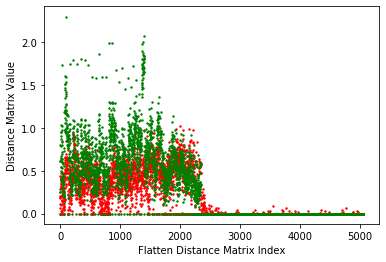

In [34]:
plt.scatter(range(X_train_results[train_show_index].shape[0]), X_train_results[train_show_index], c='r', s = 2)
plt.scatter(range(Y_train[train_show_index].shape[0]), Y_train[train_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

<function matplotlib.pyplot.show(*args, **kw)>

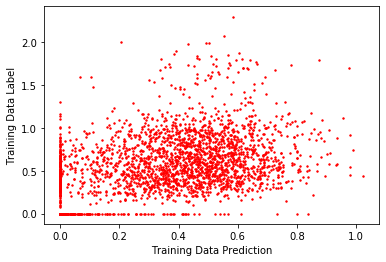

In [35]:
plt.scatter(X_train_results[train_show_index], Y_train[train_show_index], c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

In [21]:
X_train_results_resh= X_train_results.reshape((1, 425*5050))
Y_train_resh = Y_train.reshape((1, 425*5050))

<function matplotlib.pyplot.show(*args, **kw)>

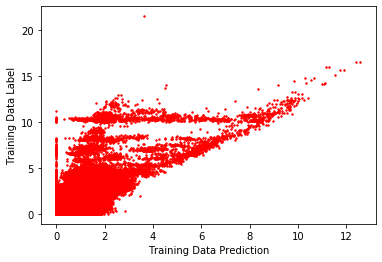

In [22]:
plt.scatter(X_train_results_resh, Y_train_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## X_test plot

In [23]:
X_test_results = model.predict(X_test)

In [24]:
test_show_index = 10

Text(0, 0.5, 'Distance Matrix Value')

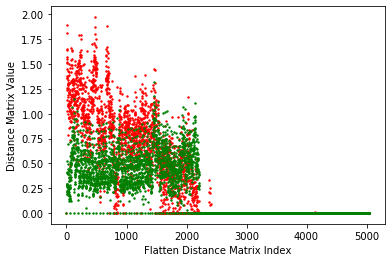

In [25]:
plt.scatter(range(X_test_results[test_show_index].shape[0]), X_test_results[test_show_index], c='r', s = 2)
plt.scatter(range(Y_test[test_show_index].shape[0]), Y_test[test_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

<function matplotlib.pyplot.show(*args, **kw)>

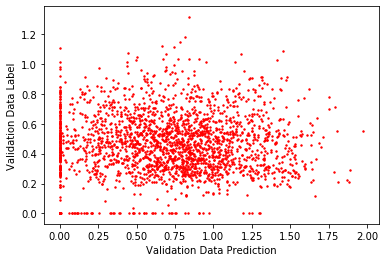

In [26]:
plt.scatter(X_test_results[train_show_index], Y_test[train_show_index], c='r', s = 2)
plt.xlabel ('Validation Data Prediction')
plt.ylabel ('Validation Data Label')
plt.show

In [27]:
X_test_results_resh= X_test_results.reshape((1, 75*5050))
Y_test_resh = Y_test.reshape((1, 75*5050))

<function matplotlib.pyplot.show(*args, **kw)>

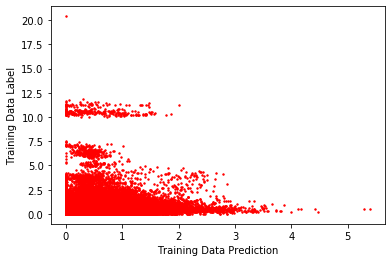

In [28]:
plt.scatter(X_test_results_resh, Y_test_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## Plot Loss 

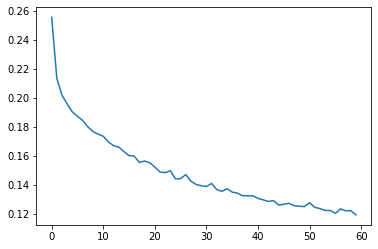

In [32]:
plt.plot(loss_list_epoch)
plt.show()

This is the loss plot for this model. I accidentally rerun the above cell and the output is erased, so I just put the result plot here.

![](https://i.imgur.com/4rqHApM.png)

## Plot RF distance

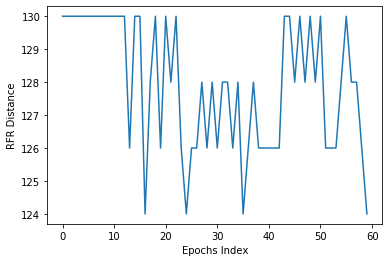

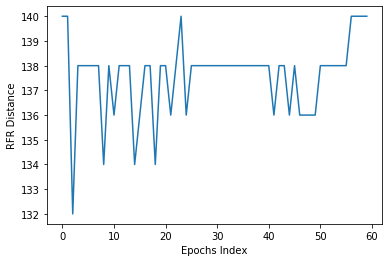

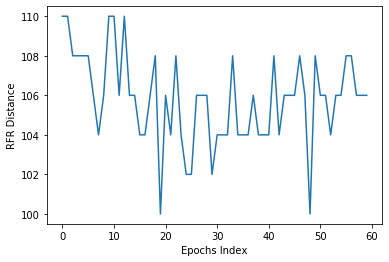

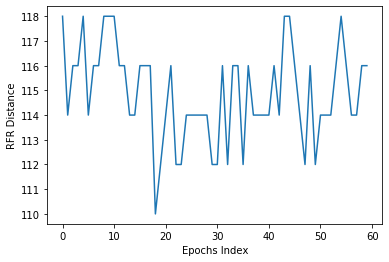

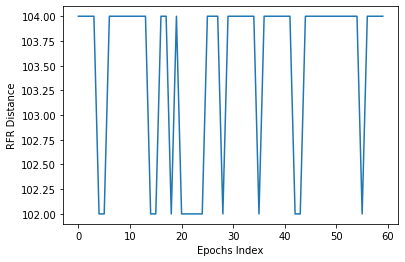

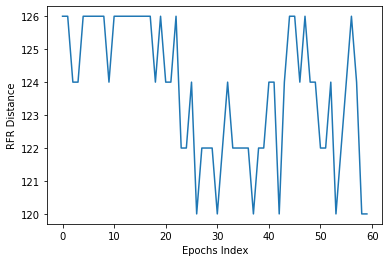

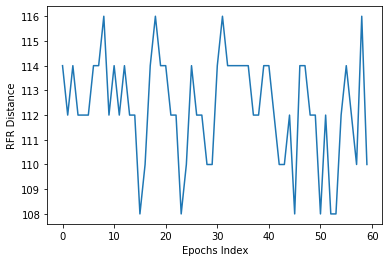

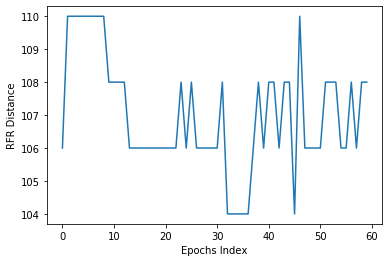

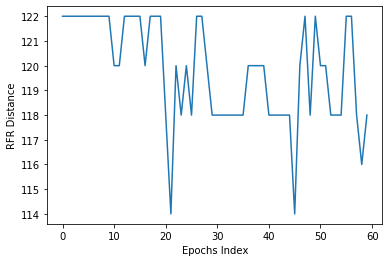

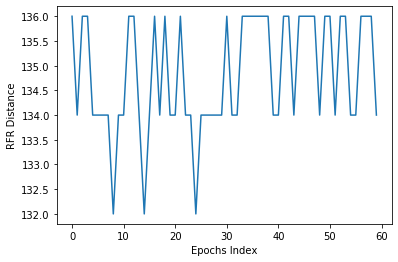

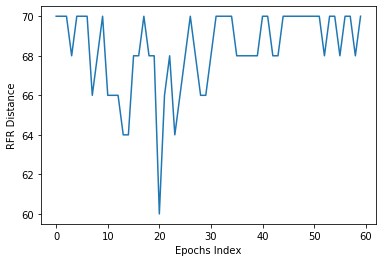

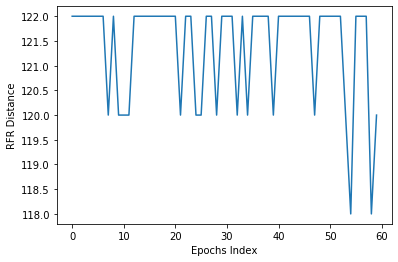

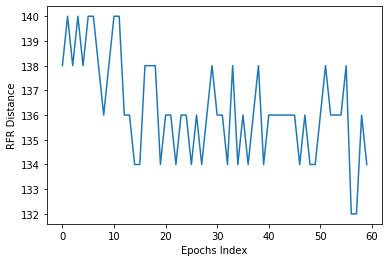

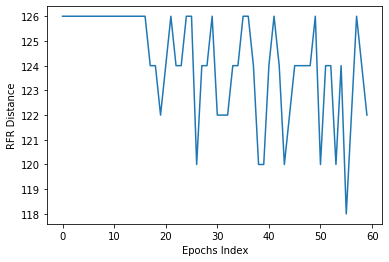

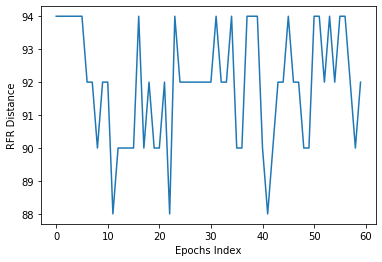

In [30]:
for index in range(15):
    index_RF_dist = [each[index] for each in RF_list_distance_epoch]
    plt.plot(index_RF_dist)
    plt.xlabel ('Epochs Index')
    plt.ylabel ('RFR Distance')
    plt.show()

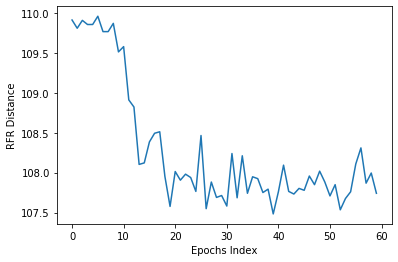

In [31]:
plt.plot(RF_avg_distance_epoch)
plt.xlabel ('Epochs Index')
plt.ylabel ('RFR Distance')
plt.show()